# EDA

In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
%matplotlib inline

In [2]:
import os
os.chdir('/home3/r09725056/Desktop/analysis-ChingYaoL')
print(os.getcwd())
# Use relative paths in the code

/home3/r09725056/Desktop/analysis-ChingYaoL


In [3]:
for file in os.listdir():
    print(file, end=' ')

input code output temp .git README.md 

#### Suggested workflow from README
* Use relative paths in the code
* Read data from _input_
* Export generated tables or figures to _output_
* Read/Write other temporary files from _temp_

In [4]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" # 讓 DataFrame Output可以重複疊起來
pd.set_option('display.max_columns', None) # show all columns

In [5]:
import datetime
# from pandas_profiling import ProfileReport

In [6]:
import contractions 
import nltk
import string
import fasttext
import contractions # resolving contractions and slangs, e.g. "yall're happy now" --> "you all are happy now"
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer

* [PyPI for fasttext](https://pypi.org/project/fasttext/)
* [medium for fasttext](https://medium.com/@c.chaitanya/language-identification-in-python-using-fasttext-60359dc30ed0)
* [GitHub for contractions](https://github.com/kootenpv/contractions)

In [7]:
# Info
# page_info = pd.read_csv(r'input/page/1000-page-info.csv')
# politician_info = pd.read_csv(r'input/page/politician-info.csv')
page_politician_info = pd.read_csv(r'input/page/1000-page-and-politician-info.csv')

# Post
top_1000_pages = pd.read_csv(r'input/post/1000-page/2015-01-01-to-2017-04-08.csv')
politician_pages = pd.read_csv(r'input/post/politician/2015-01-01-to-2016-11-30.csv')

# Reaction


In [8]:
page_politician_info.shape
top_1000_pages.shape
politician_pages.shape

(2466, 12)

(14747946, 21)

(592891, 21)

In [9]:
print(page_politician_info.columns)
print(len(page_politician_info.columns))
print(top_1000_pages.columns)
print(len(top_1000_pages.columns))
print(politician_pages.columns)
print(len(politician_pages.columns))

Index(['page_id', 'page_name', 'type', 'type_sub', 'page_url',
       'politician_name', 'party', 'chamber', 'state', 'district_rep',
       'main_page', 'post_count'],
      dtype='object')
12
Index(['page_id', 'page_name', 'post_id', 'post_type', 'post_name',
       'post_message', 'post_caption', 'post_picture', 'post_link',
       'post_description', 'post_reactions', 'post_likes', 'post_comments',
       'post_shares', 'post_created_time_CT', 'post_updated_time_CT',
       'post_created_date_CT', 'post_updated_date_CT', 'post_created_time',
       'post_updated_time', 'page_talking_about_count'],
      dtype='object')
21
Index(['page_id', 'page_name', 'post_id', 'post_type', 'post_name',
       'post_message', 'post_caption', 'post_picture', 'post_link',
       'post_description', 'post_reactions', 'post_likes', 'post_comments',
       'post_shares', 'post_created_time_CT', 'post_updated_time_CT',
       'post_created_date_CT', 'post_updated_date_CT', 'post_created_time',
       '

In [10]:
# def contract_message(x):
#     try:
#         return contractions.fix(x)
#     except IndexError:
#         return x
#     except AttributeError:
#         return x
    
def func_to_nonstring(func):
    """
    A decorator that allows a function to bypass nonstring arguments. That is, func applies only to nonstrings.
    """
    def wrapper_func(x):
        try:
            return func(x)
        except IndexError:
            return x
        except AttributeError:
            return x
    return wrapper_func

@func_to_nonstring
def contract_message(x):
    return contractions.fix(x)

In [11]:
top_1000_pages['post_message'] = top_1000_pages['post_message'].apply(contract_message)

In [12]:
top_1000_pages['post_message'].sample(5).apply(lambda x: print(x));

Cops are seeking the public's help in finding a pervert who exposed himself to a woman and threatened a man with a gun in a Midtown subway station, authorities said Wednesday. http://nydn.us/1jT002M
"Each employee gets to figure out what is best for them and their family," Netflix said. 

Will other companies follow suit?
We are headed down a slippery slope here, liberals and transgender people may get what they wish but at the same time could soon regret it....
I mean with this,what could possibly go wrong?
#America #LGBT #Equality
it is a long way from darkened basements, hooded robes and drinking from a skull.
Or maybe it is not.
What do we know? we are just the little people.
Must be nice.


In [13]:
print(top_1000_pages['post_message'].isna().sum())
print(top_1000_pages['post_message'].notna().sum())
print(f"null rate: {top_1000_pages['post_message'].isna().sum() / top_1000_pages['post_message'].notna().sum():.6f} %")

1410491
13337455
null rate: 0.105754 %


### English Lanuage Detection
The reason I use fasttext: [Benchmarking Language Detection for NLP](https://towardsdatascience.com/benchmarking-language-detection-for-nlp-8250ea8b67c)

In [34]:
pretrained_model = "/home3/r09725056/.conda/envs/usfb/lib/python3.7/site-packages/fasttext/lid.176.bin"
model = fasttext.load_model(pretrained_model)

@func_to_nonstring
def predict_language(sent):
    sent = sent.replace('\n', ' ')
    pred = model.predict(sent) # model.predict() returns a tuple like this: (('__label__en',), array([0.95346403]))
    return pred[0][0].split('_')[-1]

In [35]:
top_1000_pages['language'] = top_1000_pages['post_message'].apply(predict_language)

In [65]:
top_1000_pages['language'].value_counts(dropna=False, normalize=True).round(6)

en     0.864186
NaN    0.095640
es     0.026220
ja     0.003480
ru     0.001332
         ...   
cv     0.000000
ce     0.000000
scn    0.000000
sd     0.000000
frr    0.000000
Name: language, Length: 148, dtype: float64

In [125]:
def filter_top_unique_elements(ser, thres=0.001, ndecimal=6, show_null_rate=True):
    """
    Return top unique elements which take up no less than 0.001 (or thres) in the entire pd.Series
    This is done through ser.value_counts(normalize=True, dropna=False)
    """
    filt = (ser.value_counts(dropna=False, normalize=True) >= thres)
    if show_null_rate:
        print(f"null rate = {ser.isnull().mean() * 100:.6f} %")
    return ser.value_counts(dropna=False).loc[filt].round(ndecimal)

# filter for languages that's at least 0.1%, then assign to top_languages
lang_thres = 0.001
top_languages = filter_top_unique_elements(top_1000_pages['language'], lang_thres)

null rate = 9.563983 %


In [118]:
# A simpler way to format yticks
# fig, ax = plt.subplots(figsize=(12, 8))
# f = mticker.ScalarFormatter(useOffset=False, useMathText=True)
# g = lambda x, pos : "${}$".format(f._formatSciNotation('%1.10e' % x))
# plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(g))
# top_languages.plot.bar()

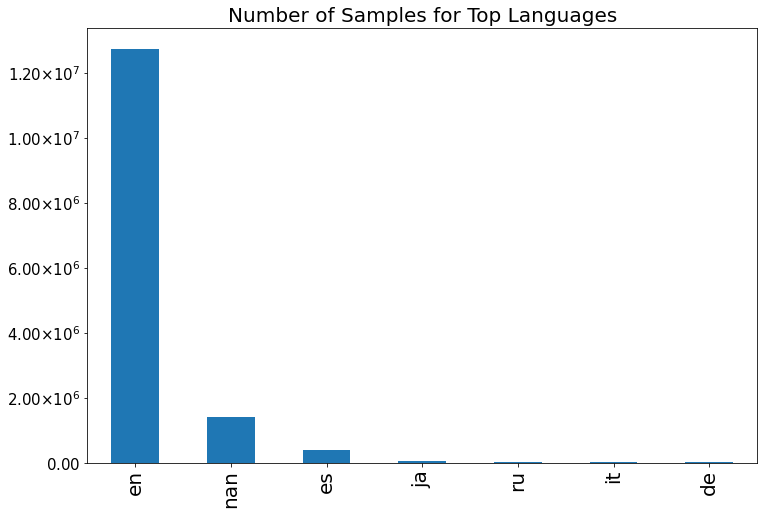

In [119]:
fig, ax = plt.subplots(figsize=(12, 8))
# Customize Yticks
class MathTextSciFormatter(mticker.Formatter):
    def __init__(self, fmt="%1.2e"):
        self.fmt = fmt
    def __call__(self, x, pos=None):
        s = self.fmt % x
        decimal_point = '.'
        positive_sign = '+'
        tup = s.split('e')
        significand = tup[0].rstrip(decimal_point)
        sign = tup[1][0].replace(positive_sign, '')
        exponent = tup[1][1:].lstrip('0')
        if exponent:
            exponent = '10^{%s%s}' % (sign, exponent)
        if significand and exponent:
            s =  r'%s{\times}%s' % (significand, exponent)
        else:
            s =  r'%s%s' % (significand, exponent)
        return "${}$".format(s)

# Format with 2 decimal places
plt.gca().yaxis.set_major_formatter(MathTextSciFormatter("%1.2e"))
# Plot Top Languages
plt.title("Number of Samples for Top Languages", size=20)
plt.xticks(size=20)
plt.yticks(size=15)
top_languages.plot.bar();

In [134]:
# filter for languages that's at least 0.01%
filter_top_unique_elements(top_1000_pages['post_name'], thres=0.0001)

null rate = 5.482309 %


Timeline Photos                                                             1398811
NaN                                                                          808528
Mobile Uploads                                                                23079
Nation In Distress                                                            10221
Occupy Democrats                                                               8409
                                                                             ...   
The Free Thought Project.com                                                   1530
GOPocalypse                                                                    1527
Fox Business                                                                   1505
Conservatives Are Destroying Our Future                                        1501
Here’s the Video That Will Finally DERAIL Hillary! Must See Documentary!       1475
Name: post_name, Length: 73, dtype: int64

In [133]:
top_1000_pages['language'].value_counts(normalize=True, dropna=False).apply(lambda x: f"{x * 100:.6f}%")

en     86.418610%
NaN     9.563983%
es      2.622019%
ja      0.347974%
ru      0.133219%
          ...    
cv      0.000007%
ce      0.000007%
scn     0.000007%
sd      0.000007%
frr     0.000007%
Name: language, Length: 148, dtype: object

In [144]:
top_1000_pages['post_type'].value_counts(dropna=False)

link         11235316
photo         2099309
video         1225049
status         182016
event            5692
note              420
music             102
offer              41
post_type           1
Name: post_type, dtype: int64

In [145]:
top_1000_pages.head()

,page_id,page_name,post_id,post_type,post_name,post_message,post_caption,post_picture,post_link,post_description,post_reactions,post_likes,post_comments,post_shares,post_created_time_CT,post_updated_time_CT,post_created_date_CT,post_updated_date_CT,post_created_time,post_updated_time,page_talking_about_count,language
0,5.444446e+10,WTHR-TV,54444461143_10153245342666144,photo,NaN,WTHR is wishing a very happy birthday to John ...,NaN,https://scontent.xx.fbcdn.net/hphotos-xpf1/v/t...,https://www.facebook.com/WTHR13/photos/a.12486...,NaN,NaN,3920739.0,97206.0,1521964.0,2015-07-25T20:35:12Z,2015-07-27T17:40:46Z,2015-07-25,2015-07-27,2015-07-26T01:35:12Z,2015-07-27T22:40:46Z,165048.0,en
1,2.637436e+11,9NEWS (KUSA),263743636076_10152822691401077,video,NaN,Thank you. Welcome home.,NaN,https://scontent.xx.fbcdn.net/v/t15.0-10/s130x...,https://www.facebook.com/ilike9news/videos/101...,NaN,1772977.0,1761230.0,76471.0,2312763.0,2014-12-31T19:49:38Z,2017-05-21T10:31:11Z,2014-12-31,2017-05-21,2015-01-01T01:49:38Z,2017-05-21T15:31:11Z,128078.0,en
2,1.143646e+14,ForAmerica,114364638621903_890023284389364,photo,Timeline Photos,Christian country singer Carrie Underwood is u...,NaN,https://scontent.xx.fbcdn.net/v/t1.0-0/s130x13...,https://www.facebook.com/ForAmerica/photos/a.1...,NaN,1639933.0,1639908.0,41595.0,146719.0,2015-01-11T18:00:00Z,2017-05-16T07:19:49Z,2015-01-11,2017-05-16,2015-01-12T00:00:00Z,2017-05-16T12:19:49Z,225676.0,en
3,2.178595e+10,9GAG,21785951839_10154491127201840,photo,Timeline Photos,This is why his speech was soooo fluent! Congr...,NaN,https://scontent.xx.fbcdn.net/hphotos-xlf1/v/t...,https://www.facebook.com/9gag/photos/a.1090410...,NaN,NaN,1626598.0,16615.0,161393.0,2016-02-28T23:16:57Z,2016-02-28T23:16:57Z,2016-02-28,2016-02-28,2016-02-29T05:16:57Z,2016-02-29T05:16:57Z,3842818.0,en
4,3.896583e+14,Right Wing News,389658314427637_956582867735176,photo,Timeline Photos,NaN,NaN,https://scontent.xx.fbcdn.net/v/t1.0-0/p130x13...,https://www.facebook.com/OfficialRightWingNews...,NaN,1574853.0,1574853.0,14681.0,154392.0,2015-01-18T23:00:01Z,2017-01-22T06:50:03Z,2015-01-18,2017-01-22,2015-01-19T05:00:01Z,2017-01-22T12:50:03Z,402776.0,NaN


In [148]:
filter_top_unique_elements(top_1000_pages['post_caption'], thres=0)
# It seems that captions are usually webpages or links

null rate = 23.338280 %


NaN                                                      3441917
madpatriots.com                                           142379
freepatriotpost.com                                       127521
libertyfirstnews.com                                      123112
conservativetribune.com                                   113824
                                                          ...   
http://bit.ly/23sFplH                                          1
http://pos.li/33js                                             1
nationaldogday.com                                             1
http://fal.cn/BOMm                                             1
http://pittsburgh.cbslocal.com/2016/10/06/furry-ta...          1
Name: post_caption, Length: 143065, dtype: int64

In [154]:
filter_top_unique_elements(top_1000_pages['post_description'], thres=0.0002)

null rate = 33.208462 %


NaN                                                                                                                                                             4897566
Posted By: Patriot Post Staff                                                                                                                                     39651
\n                                                                                                                                                                21188
Redstate News                                                                                                                                                     17450
CLICK the image to read the story!                                                                                                                                13811
Click to see the pic and write a comment...                                                                                                                     

In [156]:
cols_to_drop = ['post_picture', 'post_link']
top_1000_pages.drop(columns=cols_to_drop).head()

,page_id,page_name,post_id,post_type,post_name,post_message,post_caption,post_description,post_reactions,post_likes,post_comments,post_shares,post_created_time_CT,post_updated_time_CT,post_created_date_CT,post_updated_date_CT,post_created_time,post_updated_time,page_talking_about_count,language
0,5.444446e+10,WTHR-TV,54444461143_10153245342666144,photo,NaN,WTHR is wishing a very happy birthday to John ...,NaN,NaN,NaN,3920739.0,97206.0,1521964.0,2015-07-25T20:35:12Z,2015-07-27T17:40:46Z,2015-07-25,2015-07-27,2015-07-26T01:35:12Z,2015-07-27T22:40:46Z,165048.0,en
1,2.637436e+11,9NEWS (KUSA),263743636076_10152822691401077,video,NaN,Thank you. Welcome home.,NaN,NaN,1772977.0,1761230.0,76471.0,2312763.0,2014-12-31T19:49:38Z,2017-05-21T10:31:11Z,2014-12-31,2017-05-21,2015-01-01T01:49:38Z,2017-05-21T15:31:11Z,128078.0,en
2,1.143646e+14,ForAmerica,114364638621903_890023284389364,photo,Timeline Photos,Christian country singer Carrie Underwood is u...,NaN,NaN,1639933.0,1639908.0,41595.0,146719.0,2015-01-11T18:00:00Z,2017-05-16T07:19:49Z,2015-01-11,2017-05-16,2015-01-12T00:00:00Z,2017-05-16T12:19:49Z,225676.0,en
3,2.178595e+10,9GAG,21785951839_10154491127201840,photo,Timeline Photos,This is why his speech was soooo fluent! Congr...,NaN,NaN,NaN,1626598.0,16615.0,161393.0,2016-02-28T23:16:57Z,2016-02-28T23:16:57Z,2016-02-28,2016-02-28,2016-02-29T05:16:57Z,2016-02-29T05:16:57Z,3842818.0,en
4,3.896583e+14,Right Wing News,389658314427637_956582867735176,photo,Timeline Photos,NaN,NaN,NaN,1574853.0,1574853.0,14681.0,154392.0,2015-01-18T23:00:01Z,2017-01-22T06:50:03Z,2015-01-18,2017-01-22,2015-01-19T05:00:01Z,2017-01-22T12:50:03Z,402776.0,NaN
